In [21]:
!nvidia-smi  # Check for GPUs
!lscpu       # Check CPU info


# Detect GPU hardware
!lspci | egrep -i 'nvidia|vga|display|3d'
# Driver loaded?
!!lsmod | grep nvidia
# Torch view
!python - <<'PY'
!import torch; print("cuda_available:", torch.cuda.is_available())
!print(torch.version.cuda, torch.cuda.device_count())
!PY


Wed Sep 10 17:38:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.153.02             Driver Version: 570.153.02     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:41:00.0 Off |                  Off |
|  0%   33C    P8             30W /  480W |    2211MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
# --- DATA CLEANING & PERSISTENCE (Run Independently) ---
# Creates a permanently cleaned GeoPackage & GeoJSON with unambiguous numeric fields.
# Improvements (fix):
#   * Preserve original Percentcov (do NOT overwrite) in place; add Percentcov_lb / Percentcov_ub / Percentcov_num (alias of lb)
#   * Robust parsing for ranges ("10-25", "10 TO 25"), inequalities (">75", "<5", ">=30"), percent signs, plus signs.
#   * FORCE_RECREATE flag to rebuild cleaned outputs even if they already exist.
#   * Diagnostic summary printouts to verify distribution (catch unexpected all-zero case).
#   * InfestSqM recalculation only when missing/unusable; adds InfestSqM_source to trace provenance.
#   * Leaves original raw fields intact (Percentcov_raw, InfestAcre_raw) if they already exist.
#   * NEW: Do NOT drop rows with null geometry; instead flag them (geometry_was_null) so nothing is lost.

import os
import re
import math
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon

RAW_SHP_PATH = '/home/rbielski/SAL_Git_Projects/Cheatgrass/observations.gpkg'  # switched from filtered_cheatgrass.shp to observations.gpkg
GPKG_LAYER = None  # set to a specific layer name if observations.gpkg has multiple layers
CLEANED_GPKG_PATH = '/home/rbielski/SAL_Git_Projects/Cheatgrass/filtered_cheatgrass_cleaned.gpkg'
CLEANED_GEOJSON_PATH = '/home/rbielski/SAL_Git_Projects/Cheatgrass/filtered_cheatgrass_cleaned.geojson'
FORCE_RECREATE = True  # set False to keep existing cleaned outputs

_percent_any_pattern = re.compile(r"[-+]?\d*\.?\d+")
_range_split_pattern = re.compile(r"\s*(?:-|TO)\s*", re.IGNORECASE)

# ---------------- Parsing Helpers --------------------------------------------------
def _safe_float(x):
    try:
        return float(x)
    except Exception:
        return math.nan

def parse_percent_range(value: str):
    """Return (lower_bound, upper_bound) or (num,num) if single value.
       Handles: '10-25', '10 TO 25', '>75', '<5', '85%', '90+', '~30', '≈40', '>=15', '<=12', '97.5'.
       Inequalities: '>75' -> (75, math.nan) to preserve that it was a lower threshold; stored lb for modeling.
    """
    if value is None:
        return (math.nan, math.nan)
    s = str(value).strip()
    if s == '' or s.upper() in {"NONE", "NA", "N/A", "NULL"}:
        return (math.nan, math.nan)
    # Remove percent signs & trailing plus
    s = s.replace('%', '').rstrip('+')
    # Normalize fancy approx / inequality symbols
    s = s.replace('≈', '').replace('~', '')
    # Inequalities
    inequality = None
    if s[:2] in {'>=', '<='}:
        inequality = s[:2]
        s = s[2:]
    elif s[:1] in {'>', '<'}:
        inequality = s[:1]
        s = s[1:]
    # Ranges
    if '-' in s or ' TO ' in s.upper():
        parts = _range_split_pattern.split(s)
        if len(parts) >= 2:
            lb = _safe_float(parts[0]); ub = _safe_float(parts[1])
            return (lb, ub)
    # Single number fallback
    nums = _percent_any_pattern.findall(s)
    if not nums:
        return (math.nan, math.nan)
    num = _safe_float(nums[0])
    if inequality in ('>', '>='):
        return (num, math.nan)
    if inequality in ('<', '<='):
        return (math.nan, num)
    return (num, num)

# ---------------- Infestation Area Helper ------------------------------------------
def derive_infest_sqm(row):
    val = row.get('InfestSqM', math.nan)
    if isinstance(val, (int, float)) and not math.isnan(val) and val > 0:
        return val, 'existing'
    acre_clean = row.get('InfestAcre_clean', math.nan)
    if isinstance(acre_clean, (int, float)) and not math.isnan(acre_clean) and acre_clean > 0:
        return acre_clean * 4046.86, 'acre_converted'
    return math.nan, 'missing'

# ---------------- Cleaning Execution ------------------------------------------------
if FORCE_RECREATE and (os.path.exists(CLEANED_GPKG_PATH) or os.path.exists(CLEANED_GEOJSON_PATH)):
    print('FORCE_RECREATE=True -> removing previous cleaned outputs...')
    for p in [CLEANED_GPKG_PATH, CLEANED_GEOJSON_PATH]:
        try:
            if os.path.exists(p):
                os.remove(p)
        except Exception as e:
            print(f'Could not remove {p}: {e}')

if not os.path.exists(CLEANED_GPKG_PATH):
    print('Creating cleaned dataset ...')
    # Added robust GeoPackage layer handling
    if RAW_SHP_PATH.lower().endswith('.gpkg'):
        try:
            import fiona
            layers = fiona.listlayers(RAW_SHP_PATH)
            if GPKG_LAYER and GPKG_LAYER in layers:
                load_path = f"{RAW_SHP_PATH}|layer={GPKG_LAYER}"
            else:
                if GPKG_LAYER and GPKG_LAYER not in layers:
                    print(f"Requested layer '{GPKG_LAYER}' not found. Available: {layers}. Using first layer.")
                load_path = f"{RAW_SHP_PATH}|layer={layers[0]}"
            print(f"Loading GeoPackage layer: {load_path}")
            gdf_raw = gpd.read_file(load_path)
        except Exception as e:
            print(f"Failed GeoPackage layer read fallback to direct read: {e}")
            gdf_raw = gpd.read_file(RAW_SHP_PATH)
    else:
        gdf_raw = gpd.read_file(RAW_SHP_PATH)
    print(f'Loaded raw: {len(gdf_raw)} rows, {len(gdf_raw.columns)} cols, CRS={gdf_raw.crs}')
    print(f"Null geometry rows (before any filtering): {gdf_raw.geometry.isna().sum()}")

    # Percent cover parsing --------------------------------------------------------
    if 'Percentcov' in gdf_raw.columns:
        if 'Percentcov_raw' not in gdf_raw.columns:
            gdf_raw['Percentcov_raw'] = gdf_raw['Percentcov']
        lbs, ubs = [], []
        for v in gdf_raw['Percentcov']:
            lb, ub = parse_percent_range(v)
            lbs.append(lb); ubs.append(ub)
        gdf_raw['Percentcov_lb'] = lbs
        gdf_raw['Percentcov_ub'] = ubs
        gdf_raw['Percentcov_num'] = gdf_raw['Percentcov_lb']  # canonical
    else:
        gdf_raw['Percentcov_raw'] = math.nan
        gdf_raw['Percentcov_lb'] = math.nan
        gdf_raw['Percentcov_ub'] = math.nan
        gdf_raw['Percentcov_num'] = math.nan

    # InfestAcre cleaning ----------------------------------------------------------
    if 'InfestAcre' in gdf_raw.columns:
        if 'InfestAcre_raw' not in gdf_raw.columns:
            gdf_raw['InfestAcre_raw'] = gdf_raw['InfestAcre']
        acre_lbs = []
        for v in gdf_raw['InfestAcre']:
            lb, _ = parse_percent_range(v)
            acre_lbs.append(lb)
        gdf_raw['InfestAcre_clean'] = acre_lbs
    else:
        gdf_raw['InfestAcre_clean'] = math.nan

    # InfestSqM (numeric) ----------------------------------------------------------
    infest_vals, sources = [], []
    for _, r in gdf_raw.iterrows():
        sqm, src = derive_infest_sqm(r)
        infest_vals.append(sqm); sources.append(src)
    gdf_raw['InfestSqM'] = infest_vals
    gdf_raw['InfestSqM_source'] = sources

    # Add global_id if missing -----------------------------------------------------
    if 'global_id' not in gdf_raw.columns:
        gdf_raw['global_id'] = gdf_raw.index.astype(str)

    # Geometry handling (retain all) -----------------------------------------------
    gdf_raw['geometry_was_null'] = gdf_raw.geometry.isna()
    print(f"Geometry null rows retained (not dropped): {gdf_raw['geometry_was_null'].sum()} flagged in geometry_was_null")

    # Persist outputs --------------------------------------------------------------
    gdf_raw.to_file(CLEANED_GPKG_PATH, driver='GPKG')
    gdf_raw.to_file(CLEANED_GEOJSON_PATH, driver='GeoJSON')
    print(f'Saved cleaned dataset -> {CLEANED_GPKG_PATH} and GeoJSON copy.')

    # Diagnostics ------------------------------------------------------------------
    def _col_stats(series):
        s = pd.to_numeric(series, errors='coerce')
        return dict(count=int(s.count()), nuniq=int(s.nunique()),
                    min=float(s.min()) if s.count() else math.nan,
                    max=float(s.max()) if s.count() else math.nan,
                    zeros=int((s==0).sum()))

    print('\n[Diagnostics] Percentcov_num stats:', _col_stats(gdf_raw['Percentcov_num']))
    print('[Diagnostics] InfestSqM stats:', _col_stats(gdf_raw['InfestSqM']))
    print('[Diagnostics] InfestSqM source counts:', gdf_raw['InfestSqM_source'].value_counts(dropna=False).to_dict())

    key_cols = [c for c in ['global_id','Percentcov_raw','Percentcov_lb','Percentcov_ub','Percentcov_num','InfestAcre_raw','InfestAcre_clean','InfestSqM','InfestSqM_source','geometry_was_null'] if c in gdf_raw.columns]
    print('\nHead (key columns):')
    print(gdf_raw[key_cols].head())
else:
    print('Cleaned dataset already exists; skipping regeneration (FORCE_RECREATE=False).')

print('Data cleaning cell complete.')

FORCE_RECREATE=True -> removing previous cleaned outputs...
Creating cleaned dataset ...
Loading GeoPackage layer: /home/rbielski/SAL_Git_Projects/Cheatgrass/observations.gpkg|layer=PointLayer
Failed GeoPackage layer read fallback to direct read: /home/rbielski/SAL_Git_Projects/Cheatgrass/observations.gpkg|layer=PointLayer: No such file or directory


/home/rbielski/miniconda3/envs/geo_env/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'observations.gpkg': 'PointLayer' (default), 'PolygonLayer', 'LineLayer'. Specify layer parameter to avoid this warning.
  result = read_func(


Loaded raw: 12137 rows, 80 cols, CRS=EPSG:4326
Null geometry rows (before any filtering): 0
Geometry null rows retained (not dropped): 0 flagged in geometry_was_null
Geometry null rows retained (not dropped): 0 flagged in geometry_was_null


2025-09-10 17:38:50,431 - INFO - Created 12,137 records
2025-09-10 17:38:51,270 - INFO - Created 12,137 records
2025-09-10 17:38:51,270 - INFO - Created 12,137 records


Saved cleaned dataset -> /home/rbielski/SAL_Git_Projects/Cheatgrass/filtered_cheatgrass_cleaned.gpkg and GeoJSON copy.

[Diagnostics] Percentcov_num stats: {'count': 66, 'nuniq': 3, 'min': 0.14999999, 'max': 20.0, 'zeros': 0}
[Diagnostics] InfestSqM stats: {'count': 164, 'nuniq': 32, 'min': 40.4686, 'max': 80937200.0, 'zeros': 0}
[Diagnostics] InfestSqM source counts: {'missing': 11973, 'acre_converted': 164}

Head (key columns):
  global_id Percentcov_raw  Percentcov_lb  Percentcov_ub  Percentcov_num  \
0         0     0.14999999           0.15           0.15            0.15   
1         1     10                  10.00          10.00           10.00   
2         2     10                  10.00          10.00           10.00   
3         3     10                  10.00          10.00           10.00   
4         4     10                  10.00          10.00           10.00   

   InfestAcre_raw  InfestAcre_clean  InfestSqM InfestSqM_source  \
0            0.05              0.05    202

In [23]:
import geopandas as gpd
import pandas as pd
from IPython.display import display, HTML

# Set pandas to display all columns without truncating them
pd.set_option('display.max_columns', None)

# Use cleaned dataset produced by Cell 2
shapefile_path = '/home/rbielski/SAL_Git_Projects/Cheatgrass/filtered_cheatgrass_cleaned.gpkg'

print(f"Loading CLEANED dataset to display its header...")

try:
    gdf = gpd.read_file(shapefile_path)
    print(f"Cleaned dataset loaded. Shape: {gdf.shape}")
    display_cols = [col for col in gdf.columns if col != 'geometry']
    html = """
    <style>
        .dataframe-div { max-height: 500px; max-width: 100%; overflow: auto; border: 1px solid #ddd; }
        table.dataframe { border-collapse: collapse; width: 100%; font-family: Arial, sans-serif; color: #333333; }
        table.dataframe th { background-color: #4682b4; color: white; position: sticky; top: 0; z-index: 10; padding: 10px; text-align: left; font-weight: bold; border: 1px solid #ddd; }
        table.dataframe td { padding: 8px; text-align: left; border: 1px solid #ddd; background-color: #f9f9f9; color: #333333; }
        table.dataframe tr:nth-child(even) td { background-color: #ffffff; }
        table.dataframe tr:hover td { background-color: #e6f7ff; }
    </style>
    <div class="dataframe-div">
    """
    html += gdf[display_cols].head(100).to_html(index=True, classes='dataframe', escape=False)
    html += "</div>"
    display(HTML(html))
    print("\nColumn Names Reference:")
    for i, col in enumerate(display_cols):
        print(f"{i+1}. {col}")
    print("\nSummary statistics:")
    print(f"- Number of records: {len(gdf)}")
    print(f"- Number of columns: {len(gdf.columns)}")
    print(f"- CRS: {gdf.crs}")
except Exception as e:
    print(f"❌ An error occurred: {e}")

Loading CLEANED dataset to display its header...
Cleaned dataset loaded. Shape: (12137, 90)
Cleaned dataset loaded. Shape: (12137, 90)


,objectid,reporter,RecOwner,SciName,ComName,Nativity,OccStatus,Status,ObsDate,DateEnt,DateUp,Location,Latitude,Longitude,Datum,Method,CoordAcc,DataType,Centroid,Abundance,InfestAcre,GrossAcre,Percentcov,Density,Quantity,QuantityU,APPXQuant,NumCollect,Smallest,Largest,Incidence,Severity,Host,Host_Name,HostPheno,HostDamage,ManageStat,PopStat,Habitat,LocalOwner,Site,RecBasis,Museum,MuseumRec,Voucher,ObsIDer,CollectTme,UUID,OrgSrcID,OrigName,RecSrcTyp,Surveyor,DateAcc,VisitType,DataMthd,TrapType,NumTraps,TargetName,TargetCnt,TargetRnge,Phenology,LifeStatus,Sex,PID,WaterName,WaterType,Substrate,TreatArea,PlantTreat,TreatComm,Reference,Locality,Comments,ReviewDate,Reviewer,VerifyMthd,Verified,IDCred,ReviewComm,Percentcov_raw,Percentcov_lb,Percentcov_ub,Percentcov_num,InfestAcre_raw,InfestAcre_clean,InfestSqM,InfestSqM_source,global_id,geometry_was_null
0,1656155,Southwest Exotic Plant Mapping Program U.S. Geological Survey,Joint Federal/State/County,Bromus tectorum,"cheatgrass, downy brome",Introduced,Detected,Positive,05-21-02,05-24-11,05-24-11,"""Oneida, Idaho, United States""",42.42000,-112.66100,NAD27,None,NaN,None,None,None,0.05,NaN,0.14999999,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Unknown,None,None,Unknown,None,None,None,None,None,None,NaN,None,None,None,Bulk Data,"""MD""",NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,""" Infest Area assigned lowest cover category (<0.1) since critical data not reported. Site geographic coordinates (latitude, longitude decimal degrees) degraded to 3 decimal places.""",None,None,None,Verified,None,None,0.14999999,0.15,0.15,0.15,0.05,0.05,2.023430e+02,acre_converted,0,False
1,1726732,Idaho Department of Agriculture,State Agency,Bromus tectorum,"cheatgrass, downy brome",Introduced,Detected,Positive,06-09-05,07-13-11,07-13-11,"""Blaine, Idaho, United States""",43.31567,-114.14858,WGS84,None,NaN,None,None,None,0.10,NaN,10,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Unknown,None,None,None,None,None,None,None,None,None,NaN,None,None,None,Bulk Data,None,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,Verified,None,None,10,10.00,10.00,10.00,0.10,0.10,4.046860e+02,acre_converted,1,False
2,1726751,Idaho Department of Agriculture,State Agency,Bromus tectorum,"cheatgrass, downy brome",Introduced,Detected,Positive,06-30-05,07-13-11,07-13-11,"""Blaine, Idaho, United States""",43.31248,-114.16055,WGS84,None,NaN,None,None,None,0.10,NaN,10,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Unknown,None,None,None,None,None,None,None,None,None,NaN,None,None,None,Bulk Data,None,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,Verified,None,None,10,10.00,10.00,10.00,0.10,0.10,4.046860e+02,acre_converted,2,False
3,1726886,Idaho Department of Agriculture,State Agency,Bromus tectorum,"cheatgrass, downy brome",Introduced,Detected,Positive,07-31-05,07-13-11,07-13-11,"""Blaine, Idaho, United States""",43.31280,-114.14353,WGS84,None,NaN,None,None,None,0.10,NaN,10,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Unknown,None,None,None,None,None,None,None,None,None,NaN,None,None,None,Bulk Data,None,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,Verified,None,None,10,10.00,10.00,10.00,0.10,0.10,4.046860e+02,acre_converted,3,False
4,1731892,Idaho Department of Agriculture,State Agency,Bromus tectorum,"cheatgrass, downy brome",Introduced,Detected,Positive,01-01-03,07-13-11,07-13-11,"""Elmore, Idaho, United States""",43.29329,-115.74912,WGS84,None,NaN,None,None,None,3.00,NaN,10,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Unknown,None,None,None,None,None,None,None,None,None,NaN,None,None,None,Bulk Data,None,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,N


Column Names Reference:
1. objectid
2. reporter
3. RecOwner
4. SciName
5. ComName
6. Nativity
7. OccStatus
8. Status
9. ObsDate
10. DateEnt
11. DateUp
12. Location
13. Latitude
14. Longitude
15. Datum
16. Method
17. CoordAcc
18. DataType
19. Centroid
20. Abundance
21. InfestAcre
22. GrossAcre
23. Percentcov
24. Density
25. Quantity
26. QuantityU
27. APPXQuant
28. NumCollect
29. Smallest
30. Largest
31. Incidence
32. Severity
33. Host
34. Host_Name
35. HostPheno
36. HostDamage
37. ManageStat
38. PopStat
39. Habitat
40. LocalOwner
41. Site
42. RecBasis
43. Museum
44. MuseumRec
45. Voucher
46. ObsIDer
47. CollectTme
48. UUID
49. OrgSrcID
50. OrigName
51. RecSrcTyp
52. Surveyor
53. DateAcc
54. VisitType
55. DataMthd
56. TrapType
57. NumTraps
58. TargetName
59. TargetCnt
60. TargetRnge
61. Phenology
62. LifeStatus
63. Sex
64. PID
65. WaterName
66. WaterType
67. Substrate
68. TreatArea
69. PlantTreat
70. TreatComm
71. Reference
72. Locality
73. Comments
74. ReviewDate
75. Reviewer
76. Verif

Loaded cleaned dataset: rows=12137 cols=90 CRS=EPSG:4326
Columns: ['objectid', 'reporter', 'RecOwner', 'SciName', 'ComName', 'Nativity', 'OccStatus', 'Status', 'ObsDate', 'DateEnt', 'DateUp', 'Location', 'Latitude', 'Longitude', 'Datum', 'Method', 'CoordAcc', 'DataType', 'Centroid', 'Abundance', 'InfestAcre', 'GrossAcre', 'Percentcov', 'Density', 'Quantity', 'QuantityU', 'APPXQuant', 'NumCollect', 'Smallest', 'Largest', 'Incidence', 'Severity', 'Host', 'Host_Name', 'HostPheno', 'HostDamage', 'ManageStat', 'PopStat', 'Habitat', 'LocalOwner', 'Site', 'RecBasis', 'Museum', 'MuseumRec', 'Voucher', 'ObsIDer', 'CollectTme', 'UUID', 'OrgSrcID', 'OrigName', 'RecSrcTyp', 'Surveyor', 'DateAcc', 'VisitType', 'DataMthd', 'TrapType', 'NumTraps', 'TargetName', 'TargetCnt', 'TargetRnge', 'Phenology', 'LifeStatus', 'Sex', 'PID', 'WaterName', 'WaterType', 'Substrate', 'TreatArea', 'PlantTreat', 'TreatComm', 'Reference', 'Locality', 'Comments', 'ReviewDate', 'Reviewer', 'VerifyMthd', 'Verified', 'IDCred

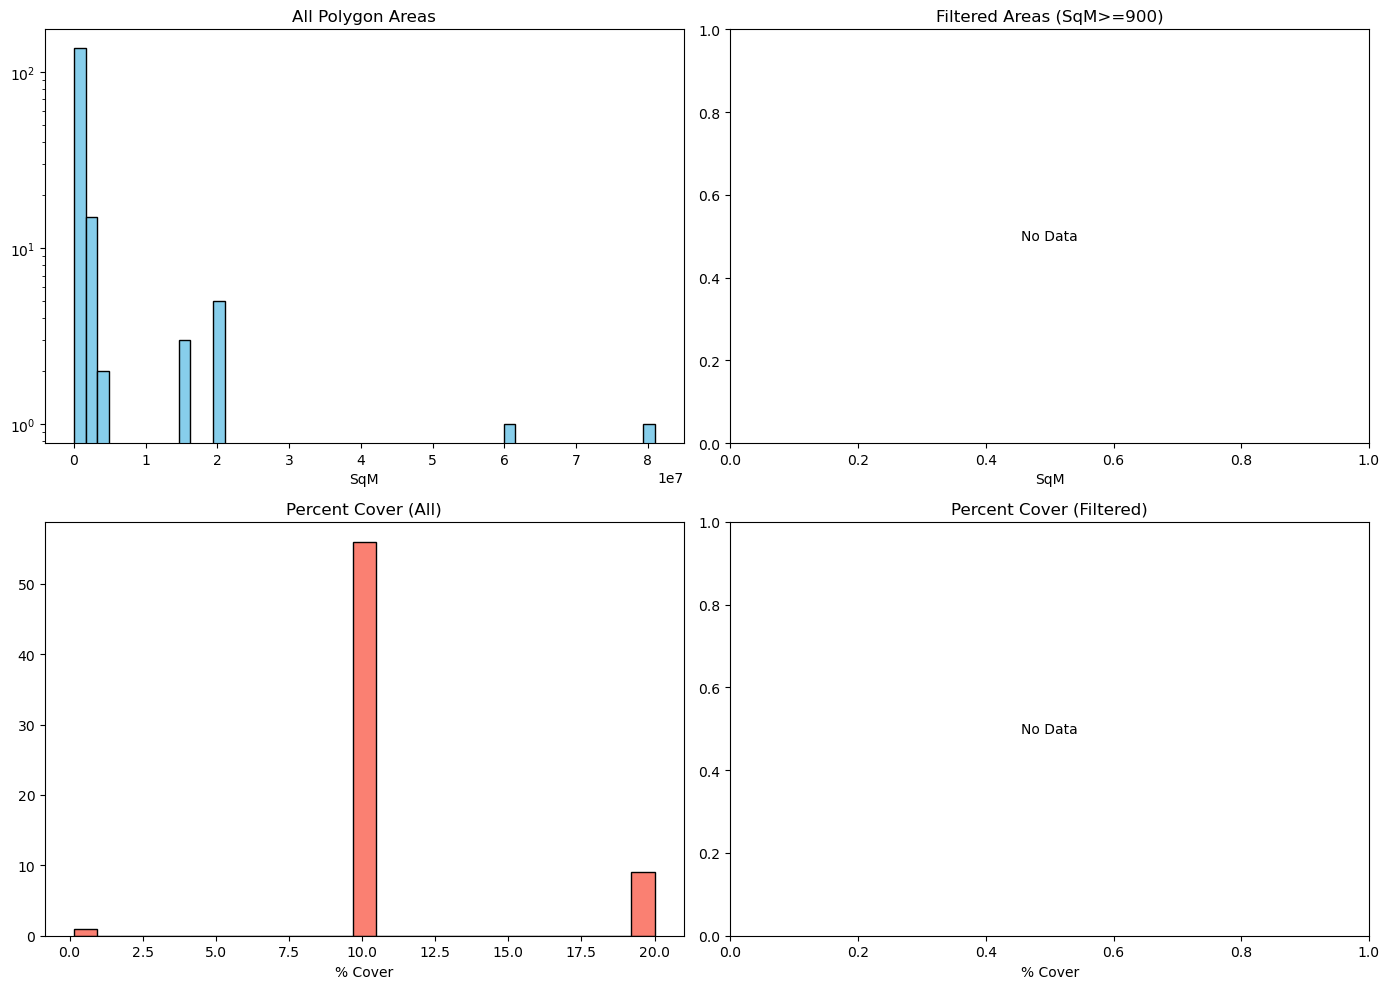

No filtered data to map.


In [24]:
# --- BLOCK 1: EXPLORATORY DATA ANALYSIS (Cleaned Dataset / Stable Version) ---
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import warnings, os, math

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', 'Geometry is in a geographic CRS', UserWarning)

CLEAN_PATH = '/home/rbielski/SAL_Git_Projects/Cheatgrass/filtered_cheatgrass_cleaned.gpkg'
MAP_SAMPLE_MAX = 1200          # reduce if still heavy
ENABLE_MAP = True              # set False to skip interactive map

try:
    gdf = gpd.read_file(CLEAN_PATH)
except Exception as e:
    print(f"Failed to read cleaned dataset: {e}")
    raise

print(f"Loaded cleaned dataset: rows={len(gdf)} cols={len(gdf.columns)} CRS={gdf.crs}")
print("Columns:", gdf.columns.tolist())
print("Head:\n", gdf.head(2))

# Ensure helper columns
if 'Percentcov_num' not in gdf.columns:
    if 'Percentcov' in gdf.columns:
        gdf['Percentcov_num'] = pd.to_numeric(gdf['Percentcov'], errors='coerce')
    else:
        gdf['Percentcov_num'] = np.nan
if 'InfestSqM' not in gdf.columns:
    if 'InfestAcre_clean' in gdf.columns:
        gdf['InfestSqM'] = gdf['InfestAcre_clean'].astype(float) * 4046.86
    elif 'InfestAcre' in gdf.columns:
        gdf['InfestSqM'] = pd.to_numeric(gdf['InfestAcre'], errors='coerce').fillna(0) * 4046.86
    else:
        gdf['InfestSqM'] = np.nan

# Basic numeric summaries (guard missing)
core_cols = [c for c in ['InfestAcre_clean','InfestSqM','Percentcov_num'] if c in gdf.columns]
print("\nSummary (selected numeric columns):")
print(gdf[core_cols].describe(include='all'))

if 'SciName' in gdf.columns:
    print("\nTop 15 SciName values:")
    print(gdf['SciName'].value_counts().head(15))

# Filter criteria
filtered_gdf = gdf[(gdf['Percentcov_num'] >= 75) & (gdf['InfestSqM'] >= 900)]
print(f"\nFilter result: {len(filtered_gdf)} / {len(gdf)} polygons (>=75% & >=900 m2)")

# Histograms (avoid plotting giant NaN arrays)
def safe_hist(data, bins, ax, title, xlabel, log=False, color='steelblue'):
    arr = pd.to_numeric(data, errors='coerce').dropna()
    if arr.empty:
        ax.text(0.5,0.5,'No Data', ha='center', va='center')
    else:
        ax.hist(arr, bins=bins, color=color, edgecolor='black')
        if log:
            ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel(xlabel)

fig, axes = plt.subplots(2,2, figsize=(14,10))
safe_hist(gdf['InfestSqM'], 50, axes[0,0], 'All Polygon Areas', 'SqM', log=True, color='skyblue')
safe_hist(filtered_gdf['InfestSqM'], 50, axes[0,1], 'Filtered Areas (SqM>=900)', 'SqM', log=True, color='lightgreen')
safe_hist(gdf['Percentcov_num'], 25, axes[1,0], 'Percent Cover (All)', '% Cover', color='salmon')
safe_hist(filtered_gdf['Percentcov_num'], 25, axes[1,1], 'Percent Cover (Filtered)', '% Cover', color='orchid')
plt.tight_layout(); plt.show()

# --- Mapping (lightweight + robust) ------------------------------------------------
if ENABLE_MAP and len(filtered_gdf) > 0:
    map_df = filtered_gdf.copy()
    # Fix invalid geometries cheaply if present (may prevent GEOS crashes)
    invalid_ct = (~map_df.geometry.is_valid).sum()
    if invalid_ct:
        print(f"Fixing {invalid_ct} invalid geometries via buffer(0)...")
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            map_df['geometry'] = map_df.buffer(0)
        map_df = map_df[map_df.geometry.notna() & map_df.geometry.is_valid]
        print(f"After fix: {len(map_df)} geometries remain")

    map_df = map_df[map_df.geometry.notna() & ~map_df.geometry.is_empty]
    if map_df.empty:
        print('No valid geometries for mapping after cleanup.')
    else:
        # Use representative_point (faster, avoids centroid robustness issues)
        try:
            reps = map_df.representative_point()
        except Exception as e:
            print(f"representative_point failed ({e}); falling back to centroid")
            reps = map_df.geometry.centroid
        map_df = map_df.assign(lon=reps.x, lat=reps.y)
        map_df = map_df.dropna(subset=['lon','lat'])
        # Sample to reduce plotting overhead
        if len(map_df) > MAP_SAMPLE_MAX:
            map_df = map_df.sample(MAP_SAMPLE_MAX, random_state=42)
            print(f"Map sample truncated to {MAP_SAMPLE_MAX} points for performance.")
        if len(map_df) > 0:
            try:
                fig = px.scatter_mapbox(
                    map_df,
                    lat='lat', lon='lon',
                    color='Percentcov_num', size='InfestSqM', size_max=14,
                    zoom=5, opacity=0.7,
                    title='Cheatgrass (Filtered) - Sampled Points',
                    color_continuous_scale=px.colors.sequential.Viridis,
                    hover_data=[c for c in ['SciName','Percentcov_num','InfestSqM'] if c in map_df.columns]
                )
                fig.update_layout(mapbox_style='open-street-map', margin={'r':0,'t':40,'l':0,'b':0}, height=550)
                fig.show()
            except Exception as e:
                print(f"Plotly map failed: {e}")
        else:
            print('No points left after sampling / cleanup for map.')
else:
    if not ENABLE_MAP:
        print('Map disabled (ENABLE_MAP=False).')
    else:
        print('No filtered data to map.')

# --- Optional: save filtered subset ------------------------------------------------
if len(filtered_gdf) > 0:
    out_path = '/home/rbielski/SAL_Git_Projects/Cheatgrass/filtered_cheatgrass_cleaned.geojson'
    try:
        filtered_gdf.to_file(out_path, driver='GeoJSON')
        print(f'Saved filtered subset to {out_path}')
    except Exception as e:
        print(f'Failed to save filtered subset: {e}')

In [ ]:
# =================================================================================
# --- CHEATGRASS DATA PROCESSING PIPELINE (Cleaned Dataset) -----------------------
# (Augmented with diagnostics to explain empty experimental sets)                 
# =================================================================================
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore", message="The get_cmap function was deprecated", category=DeprecationWarning)
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# ----------------------------- CONFIG -------------------------------------------
shapefile_path = '/home/rbielski/SAL_Git_Projects/Cheatgrass/filtered_cheatgrass_cleaned.gpkg'
percent_variations = [10, 25, 50, 66.6, 75]
area_variations = [100, 250, 500, 750, 900]   # square meters thresholds
TARGET_CRS = 'EPSG:32611'
CHEATGRASS_ALIASES = {'CHEATGRASS', 'DOWNY BROME', 'BROMUS TECTORUM', 'B. TECTORUM', 'BROMUS  TECTORUM'}
MIN_GEOFALLBACK_AREA = 1.0  # treat <= this as missing InfestSqM so we can fallback to geometry

def load_and_prepare_cheatgrass(filepath: str) -> gpd.GeoDataFrame:
    print('\n--- Loading Cleaned Cheatgrass Dataset ---')
    gdf = gpd.read_file(filepath)
    print(f'✅ Loaded {len(gdf)} rows | {len(gdf.columns)} columns')

    # primary_sp_percent from Percentcov_num (already cleaned)
    if 'primary_sp_percent' not in gdf.columns:
        if 'Percentcov_num' in gdf.columns:
            gdf['primary_sp_percent'] = gdf['Percentcov_num'].fillna(0)
        elif 'Percentcov' in gdf.columns:
            gdf['primary_sp_percent'] = pd.to_numeric(gdf['Percentcov'], errors='coerce').fillna(0)
        else:
            gdf['primary_sp_percent'] = 0

    # InfestSqM ensured (but may be zero / unusable)
    if 'InfestSqM' not in gdf.columns:
        if 'InfestAcre_clean' in gdf.columns:
            gdf['InfestSqM'] = gdf['InfestAcre_clean'].fillna(0) * 4046.86
        else:
            gdf['InfestSqM'] = 0.0

    # Species name -> uppercase
    if 'SciName' in gdf.columns:
        gdf['primary_sp'] = gdf['SciName'].astype(str).str.upper().str.strip()
    else:
        gdf['primary_sp'] = 'UNKNOWN'

    # Presence flag (still stored as is_vedu_present for reuse downstream)
    if 'is_vedu_present' not in gdf.columns:
        gdf['is_vedu_present'] = gdf['primary_sp'].apply(lambda x: 1 if any(a in x for a in CHEATGRASS_ALIASES) else 0)
    gdf['is_vedu_present'] = gdf['is_vedu_present'].fillna(0).astype(int)

    if 'global_id' not in gdf.columns:
        gdf['global_id'] = gdf.index.astype(str)

    # Keep only valid geometries
    gdf = gdf[gdf.geometry.notna() & ~gdf.geometry.is_empty].copy()
    print(f'✅ Geometry-valid rows: {len(gdf)}')
    # Quick preview of key columns
    preview_cols = [c for c in ['global_id','primary_sp','primary_sp_percent','InfestSqM','is_vedu_present'] if c in gdf.columns]
    print(gdf[preview_cols].head())
    return gdf

def _diagnostic_counts(df, label):
    if df.empty: return
    print(f'[{label}] class balance is_vedu_present ->', df['is_vedu_present'].value_counts().to_dict())
    if 'primary_sp_percent' in df.columns:
        print(f'[{label}] primary_sp_percent stats -> min={df.primary_sp_percent.min()} max={df.primary_sp_percent.max()} unique={sorted(df.primary_sp_percent.unique())[:10]}')
    if 'InfestSqM' in df.columns:
        print(f'[{label}] InfestSqM summary (non-null) -> count={(df.InfestSqM>0).sum()} zeros={(df.InfestSqM<=0).sum()}')

def generate_experimental_datasets_with_controls(filepath: str,
                                                 percent_thresholds: list,
                                                 area_thresholds: list,
                                                 target_crs=TARGET_CRS,
                                                 test_size=0.2,
                                                 random_state=42):
    base_gdf = load_and_prepare_cheatgrass(filepath)
    _diagnostic_counts(base_gdf, 'BASE')

    # Split (fallback to random if only one class)
    if base_gdf['is_vedu_present'].nunique() < 2 or len(base_gdf) < 4:
        print('⚠ Not enough class diversity or too few rows for stratified split; using random split.')
        master_train_gdf, final_test_set = train_test_split(base_gdf, test_size=min(0.5, test_size), random_state=random_state)
    else:
        master_train_gdf, final_test_set = train_test_split(
            base_gdf, test_size=test_size,
            stratify=base_gdf['is_vedu_present'], random_state=random_state
        )
    print('\n--- Master Sets Created ---')
    print(f'Master Training Set: {len(master_train_gdf)} | Final Test Set: {len(final_test_set)}')
    _diagnostic_counts(master_train_gdf, 'TRAIN')

    # Reproject + robust area fallback
    reprojected = master_train_gdf.to_crs(target_crs)
    reprojected['geom_area_sqm'] = reprojected.geometry.area

    if 'InfestSqM' in reprojected.columns:
        # Correct fallback: use InfestSqM unless missing/too small, then geometry area
        reprojected['area_sqm'] = reprojected['InfestSqM'].where(~(reprojected['InfestSqM'].isna() | (reprojected['InfestSqM'] <= MIN_GEOFALLBACK_AREA)), reprojected['geom_area_sqm'])
    else:
        reprojected['area_sqm'] = reprojected['geom_area_sqm']

    print('\nArea diagnostics:')
    print(reprojected[['global_id','InfestSqM','geom_area_sqm','area_sqm']].head())
    print('area_sqm stats ->', reprojected['area_sqm'].describe())

    training_datasets = {}
    print('\n--- Generating Experimental Datasets ---')
    for pct in percent_thresholds:
        for area in area_thresholds:
            name = f'percent_{pct}_area_{area}'
            # NOTE: use >= for percent to avoid excluding exact threshold values
            pos_mask = ((reprojected['is_vedu_present'] == 1) &
                        (reprojected['primary_sp_percent'] >= pct) &
                        (reprojected['area_sqm'] >= area))
            ctrl_mask = ((reprojected['is_vedu_present'] == 0) &
                         (reprojected['area_sqm'] >= area))
            pos_subset = reprojected[pos_mask]
            ctrl_subset = reprojected[ctrl_mask]
            combined = pd.concat([pos_subset, ctrl_subset], ignore_index=True)
            print(f"\n>> {name}")
            print(f'  - Pos (cheatgrass) count: {len(pos_subset)}')
            print(f'  - Ctrl count: {len(ctrl_subset)}')
            if len(reprojected):
                print(f'  - Pos area filter keep %: {100*len(pos_subset)/len(reprojected):.1f}% | Ctrl keep %: {100*len(ctrl_subset)/len(reprojected):.1f}%')
            if len(pos_subset)==0 and len(ctrl_subset)==0:
                # Provide specific reasons when both empty
                failing = reprojected[(reprojected['is_vedu_present']==1)]
                if not failing.empty:
                    print('    Diagnostics (positive class candidates):')
                    print(failing[['global_id','primary_sp_percent','area_sqm']])
            training_datasets[name] = combined.copy()

    print('\n✅ Dataset generation complete.')
    return training_datasets, final_test_set

# -------------------------------- EXECUTION -------------------------------------
experimental_sets, final_test_set = generate_experimental_datasets_with_controls(
    filepath=shapefile_path,
    percent_thresholds=percent_variations,
    area_thresholds=area_variations,
    target_crs=TARGET_CRS
)

print(f"\nSummary of generated experimental sets: {len(experimental_sets)} total")
first_key = next(iter(experimental_sets.keys())) if experimental_sets else None
if first_key:
    sample_df = experimental_sets[first_key]
    print(f"Example set '{first_key}' rows: {len(sample_df)} | Columns: {list(sample_df.columns)[:12]} ...")


--- Loading Cleaned Cheatgrass Dataset ---
✅ Loaded 12137 rows | 90 columns
✅ Geometry-valid rows: 12137
  global_id       primary_sp  primary_sp_percent  InfestSqM  is_vedu_present
0         0  BROMUS TECTORUM                0.15    202.343                1
1         1  BROMUS TECTORUM               10.00    404.686                1
2         2  BROMUS TECTORUM               10.00    404.686                1
3         3  BROMUS TECTORUM               10.00    404.686                1
4         4  BROMUS TECTORUM               10.00  12140.580                1
[BASE] class balance is_vedu_present -> {1: 12137}
[BASE] primary_sp_percent stats -> min=0.0 max=20.0 unique=[0.0, 0.14999999, 10.0, 20.0]
[BASE] InfestSqM summary (non-null) -> count=164 zeros=0
⚠ Not enough class diversity or too few rows for stratified split; using random split.

--- Master Sets Created ---
Master Training Set: 9709 | Final Test Set: 2428
[TRAIN] class balance is_vedu_present -> {1: 9709}
[TRAIN] primary_sp_

In [29]:
# IMPORTANT: Set your Earthdata Login token here or as an environment variable
import os
import requests
import geopandas as gpd
import pandas as pd
import numpy as np
import tempfile
import shutil
import rasterio
from rasterio.features import rasterize
from urllib.parse import urlparse
import re
import time
from pathlib import Path
from datetime import datetime
import json
import logging

# Initialize logger
logger = logging.getLogger(__name__)
if not logger.handlers:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Auth helpers ---
TOKEN_FILE_CANDIDATES = [
    str(Path.home() / ".earthdata_token"),
    "/home/rbielski/SAL_Git_Projects/earthdata_token.txt"
]

def load_earthdata_token() -> str:
    """Load token from env or common local files; return '' if not found."""
    tok = os.getenv("EARTHDATA_LOGIN_TOKEN", "").strip()
    if tok:
        return tok
    for p in TOKEN_FILE_CANDIDATES:
        try:
            if os.path.exists(p):
                with open(p, "r") as f:
                    tok = f.read().strip()
                    if tok:
                        os.environ["EARTHDATA_LOGIN_TOKEN"] = tok
                        logger.info(f"Loaded Earthdata token from {p}")
                        return tok
        except Exception:
            continue
    return ""

# Auth: prefer environment variable; no hardcoded secrets
token = load_earthdata_token()
headers = {"Authorization": f"Bearer {token}"} if token else {}
if not token:
    raise RuntimeError("Earthdata Login Token not found. Set EARTHDATA_LOGIN_TOKEN or create earthdata_token.txt.")

# Bands & sizing
BANDS_OF_INTEREST = ["B02", "B03", "B04", "B05", "B07", "B11"]
CONTEXT_SIZE_CHEATGRASS = 96
CONTEXT_SIZE_CONTROL = 32
TRAINING_WINDOW_SIZE = 32
DATE_RANGE_START = "2024-05-01"
DATE_RANGE_END   = "2024-10-31"
OUTPUT_DIR = Path("vedu_unet_data")  # align with VEDU tooling
OUTPUT_DIR.mkdir(exist_ok=True)
REQUEST_SLEEP = 0.5  # align with VEDU

# URL helper to handle S3 links gracefully
def to_https_if_s3(url: str) -> str:
    if not url:
        return url
    if url.startswith("s3://"):
        # Best-effort conversion; many CMR links have HTTPS equivalents
        return "https://" + url[len("s3://"):]
    return url

# ------------------------- HELPER FUNCTIONS --------------------------------------

def format_bbox_for_cmr(bbox_geometry, input_crs="EPSG:32611"):
    gs = gpd.GeoSeries([bbox_geometry], crs=input_crs).to_crs(epsg=4326).iloc[0]
    minx, miny, maxx, maxy = gs.bounds
    return f"{minx},{miny},{maxx},{maxy}"

def find_granule_urls_by_date(bbox_geometry, start_date, end_date, max_retries=5, initial_delay=2):
    bbox_wgs84_str = format_bbox_for_cmr(bbox_geometry)
    params = {
        "short_name": "HLSL30",
        "temporal": f"{start_date}T00:00:00Z,{end_date}T23:59:59Z",
        "bounding_box": bbox_wgs84_str,
        "page_size": 2000
    }
    retries, delay = 0, initial_delay
    while retries <= max_retries:
        try:
            logger.info("Searching granules%s" % (f" (retry {retries})" if retries else ""))
            r = requests.get("https://cmr.earthdata.nasa.gov/search/granules.umm_json", headers=headers, params=params, timeout=45)
            r.raise_for_status()
            items = r.json().get("items", [])
            logger.info(f"Found {len(items)} candidate granule records")
            date_grouped = {}
            for it in items:
                umm = it.get("umm", {})
                granule_id = umm.get("GranuleUR", "")
                m = re.search(r'\.(\d{4})(\d{3})T', granule_id)
                if not m:
                    continue
                acq_date = datetime.strptime(f"{m.group(1)}-{m.group(2)}", "%Y-%j").strftime("%Y-%m-%d")
                date_grouped.setdefault(acq_date, {})
                for url_info in umm.get("RelatedUrls", []):
                    u = url_info.get("URL", "")
                    t = url_info.get("Type", "")
                    if t != "GET DATA" or not u.endswith(".tif"):
                        continue
                    url = to_https_if_s3(u)
                    if "Fmask" in url:
                        date_grouped[acq_date]["Fmask"] = url
                    else:
                        for band in BANDS_OF_INTEREST:
                            if f".{band}." in url or f"_{band}." in url:
                                date_grouped[acq_date][band] = url
                                break
            return date_grouped
        except requests.RequestException as e:
            logger.warning(f"Granule search error (retry {retries}/{max_retries}): {e}")
            time.sleep(delay); retries += 1; delay *= 2
    logger.error("Granule retrieval failed after retries.")
    return {}

def download_and_extract_data(url, polygon_geom, context_size):
    url = to_https_if_s3(url)
    with tempfile.TemporaryDirectory() as tmp:
        fname = os.path.basename(urlparse(url).path)
        fpath = Path(tmp)/fname
        try:
            resp = requests.get(url, headers=headers, stream=True, timeout=60)
            resp.raise_for_status()
            with open(fpath, 'wb') as f:
                shutil.copyfileobj(resp.raw, f)
            with rasterio.open(fpath) as src:
                poly_src = gpd.GeoSeries([polygon_geom], crs="EPSG:32611").to_crs(src.crs).iloc[0]
                cx, cy = poly_src.centroid.x, poly_src.centroid.y
                row, col = src.index(cx, cy)
                half = context_size // 2
                h, w = src.height, src.width
                c0, r0 = max(0, col - half), max(0, row - half)
                c1, r1 = min(w, col + half), min(h, row + half)
                actual_w, actual_h = c1 - c0, r1 - r0
                if context_size == CONTEXT_SIZE_CHEATGRASS:
                    coverage = (actual_w * actual_h) / (context_size * context_size)
                    if coverage < 0.75:
                        logger.debug(f"Coverage {coverage:.2%} too low for 96x96 window; skip")
                        return None, None, None
                window = rasterio.windows.Window(c0, r0, actual_w, actual_h)
                data = src.read(1, window=window)
                tr = src.window_transform(window)
                if data.shape != (context_size, context_size):
                    pad_h = context_size - data.shape[0]
                    pad_w = context_size - data.shape[1]
                    if context_size == CONTEXT_SIZE_CHEATGRASS and max(pad_h, pad_w) > context_size * 0.25:
                        return None, None, None
                    nodata = 0 if src.nodata is None else src.nodata
                    padded = np.full((context_size, context_size), nodata, dtype=data.dtype)
                    padded[:data.shape[0], :data.shape[1]] = data
                    data = padded
                return data, tr, src.crs
        except Exception as e:
            logger.warning(f"Band download/extract failed {url}: {e}")
            return None, None, None

def is_pixel_contaminated(fmask_value: int) -> bool:
    v = int(fmask_value)
    return any([
        (v & (1 << 1)) > 0,   # cloud
        (v & (1 << 3)) > 0,   # shadow
        (v & (1 << 4)) > 0,   # snow
        (((v >> 6) & 0b11) == 0b11)  # high aerosol
    ])

def create_segmentation_mask(polygon_geom, image_transform, image_crs, context_size):
    poly_img = gpd.GeoSeries([polygon_geom], crs="EPSG:32611").to_crs(image_crs).iloc[0]
    return rasterize(
        shapes=[(poly_img, 1)],
        out_shape=(context_size, context_size),
        transform=image_transform,
        fill=0,
        all_touched=True,
        dtype=rasterio.uint8
    )

def determine_context_size(is_cheatgrass_present: bool) -> int:
    return CONTEXT_SIZE_CHEATGRASS if is_cheatgrass_present else CONTEXT_SIZE_CONTROL

def save_metadata(global_id, is_cheatgrass_present, context_size, num_obs, quality_info=None):
    meta = {
        'global_id': global_id,
        'is_cheatgrass_present': bool(is_cheatgrass_present),
        'is_vedu_present': bool(is_cheatgrass_present),  # align key with VEDU
        'context_size': context_size,
        'num_observations': num_obs,
        'training_window_size': TRAINING_WINDOW_SIZE,
        'processed_timestamp': datetime.utcnow().isoformat()+"Z",
        'quality_info': quality_info or {}
    }
    with open(OUTPUT_DIR / f"{global_id}_metadata.json", 'w') as f:
        json.dump(meta, f, indent=2)

# ------------------------- CORE PROCESSING ---------------------------------------

def process_unique_polygon_list(unique_polygons_gdf: gpd.GeoDataFrame):
    summary = {"cheatgrass_96x96": 0, "control_32x32": 0, "skipped": 0}
    for idx, row in unique_polygons_gdf.iterrows():
        # Removed max polygon early-stop
        gid = row['global_id']
        geom = row['geometry']
        is_cg = bool(row.get('is_cheatgrass_present', row.get('is_vedu_present', 0)))
        ctx_size = determine_context_size(is_cg)
        ctx_label = "CHEATGRASS (96x96)" if is_cg else "CONTROL (32x32)"
        logger.info(f"\n--- {idx+1}/{len(unique_polygons_gdf)} {gid} [{ctx_label}] ---")

        data_path = OUTPUT_DIR / f"{gid}_data.npy"
        mask_path = OUTPUT_DIR / f"{gid}_mask.npy"
        meta_path = OUTPUT_DIR / f"{gid}_metadata.json"
        if data_path.exists() and mask_path.exists() and meta_path.exists():
            logger.info("Already processed; skipping.")
            continue

        granule_dates = find_granule_urls_by_date(geom, DATE_RANGE_START, DATE_RANGE_END)
        if not granule_dates:
            logger.info("No granules found; skip polygon.")
            summary['skipped'] += 1
            continue

        obs_data, obs_masks = [], []
        skipped_partial = 0
        skipped_contaminated = 0

        for date, band_urls in sorted(granule_dates.items()):
            if "Fmask" not in band_urls:
                continue
            fmask_chip, _, _ = download_and_extract_data(band_urls['Fmask'], geom, ctx_size)
            if fmask_chip is None:
                skipped_partial += 1; continue
            center = ctx_size // 2
            if is_pixel_contaminated(fmask_chip[center, center]):
                skipped_contaminated += 1; continue
            bands_stack = []
            final_tr = final_crs = None
            all_ok = True
            for band in BANDS_OF_INTEREST:
                if band not in band_urls: all_ok = False; break
                bdata, tr, crs = download_and_extract_data(band_urls[band], geom, ctx_size)
                if bdata is None:
                    all_ok = False; break
                bands_stack.append(bdata)
                if final_tr is None: final_tr, final_crs = tr, crs
            if not all_ok or final_tr is None:
                skipped_partial += 1; continue
            chip = np.stack(bands_stack, axis=-1)
            mask = create_segmentation_mask(geom, final_tr, final_crs, ctx_size)
            obs_data.append(chip)
            obs_masks.append(mask)
            # polite pause
            time.sleep(REQUEST_SLEEP)

        if obs_data:
            data_arr = np.stack(obs_data, axis=0)   # (T,H,W,C)
            mask_arr = np.stack(obs_masks, axis=0)  # (T,H,W)
            np.save(data_path, data_arr)
            np.save(mask_path, mask_arr)
            save_metadata(
                gid, is_cg, ctx_size, len(obs_data),
                quality_info={
                    'observations_saved': len(obs_data),
                    'skipped_partial': skipped_partial,
                    'skipped_contaminated': skipped_contaminated,
                    'total_dates_processed': len(granule_dates)
                }
            )
            if is_cg:
                summary['cheatgrass_96x96'] += 1
            else:
                summary['control_32x32'] += 1
            logger.info(f"Saved {len(obs_data)} obs | data {data_arr.shape} mask {mask_arr.shape}")
        else:
            logger.info("No clear observations kept.")
            summary['skipped'] += 1

    logger.info("\n================ SUMMARY ===============")
    for k,v in summary.items(): logger.info(f"{k}: {v}")
    logger.info("========================================")

# ------------------------- EXECUTION WRAPPER -------------------------------------
if 'experimental_sets' in globals() and 'final_test_set' in globals():
    print("\n--- Preparing unique polygon list for CHEATGRASS imagery ingestion ---")
    # Combine all experiment GDFs + final test set
    train_gdfs = [gdf for gdf in experimental_sets.values() if not gdf.empty]
    if not train_gdfs:
        print("No experimental sets available; abort imagery step.")
    else:
        # Ensure final_test_set CRS matches experiments
        try:
            exp_crs = train_gdfs[0].crs or 'EPSG:32611'
            test_reproj = final_test_set.to_crs(exp_crs)
        except Exception:
            test_reproj = final_test_set
        master = pd.concat(train_gdfs + [test_reproj], ignore_index=True)
        master = master.drop_duplicates(subset=['global_id']).copy()
        # Removed sampling block (previously limited polygon count)
        # Add alias column
        if 'is_cheatgrass_present' not in master.columns and 'is_vedu_present' in master.columns:
            master['is_cheatgrass_present'] = master['is_vedu_present']
        elif 'is_cheatgrass_present' not in master.columns:
            master['is_cheatgrass_present'] = 0
        print(f"Unique polygons: {len(master)} (Cheatgrass positives: {master['is_cheatgrass_present'].sum()})")
        # Filter out null/empty geometries defensively
        master = master[master.geometry.notna() & ~master.geometry.is_empty]
        if master.empty:
            print("No valid geometries to process.")
        else:
            process_unique_polygon_list(master)
else:
    print("Required variables experimental_sets / final_test_set not found. Run previous pipeline cell first.")

2025-09-11 09:33:22,583 - ERROR - Earthdata Login Token is not set. Proceeding without Authorization header; some requests may fail.
2025-09-11 09:33:22,618 - INFO - 
--- 1/2474 29 [CHEATGRASS (96x96)] ---
2025-09-11 09:33:22,623 - INFO - Searching granules
2025-09-11 09:33:22,618 - INFO - 
--- 1/2474 29 [CHEATGRASS (96x96)] ---
2025-09-11 09:33:22,623 - INFO - Searching granules



--- Preparing unique polygon list for CHEATGRASS imagery ingestion ---
Unique polygons: 2474 (Cheatgrass positives: 2474)


2025-09-11 09:33:23,404 - INFO - Found 22 candidate granule records
2025-09-11 09:33:23,410 - WARNING - Band download/extract failed https://lp-prod-protected/HLSL30.020/HLS.L30.T12TUP.2024134T181221.v2.0/HLS.L30.T12TUP.2024134T181221.v2.0.Fmask.tif: HTTPSConnectionPool(host='lp-prod-protected', port=443): Max retries exceeded with url: /HLSL30.020/HLS.L30.T12TUP.2024134T181221.v2.0/HLS.L30.T12TUP.2024134T181221.v2.0.Fmask.tif (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x760037034f10>: Failed to resolve 'lp-prod-protected' ([Errno -3] Temporary failure in name resolution)"))
2025-09-11 09:33:23,412 - WARNING - Band download/extract failed https://lp-prod-protected/HLSL30.020/HLS.L30.T12TUP.2024142T181238.v2.0/HLS.L30.T12TUP.2024142T181238.v2.0.Fmask.tif: HTTPSConnectionPool(host='lp-prod-protected', port=443): Max retries exceeded with url: /HLSL30.020/HLS.L30.T12TUP.2024142T181238.v2.0/HLS.L30.T12TUP.2024142T181238.v2.0.Fmask.tif (Caused by NameResol

KeyboardInterrupt: 